In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def plot(x, **kwargs) -> None:
    xlabel, ylabel, title = kwargs.get("x_label", ""), kwargs.get("y_label", ""), kwargs.get("title", "")
    plt.plot(x)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [4]:
df = pl.scan_csv("../data/train.csv")
meals = pl.scan_csv("../data/meal_info.csv")
center_info = pl.scan_csv("../data/fulfilment_center_info.csv")

df = df.join(meals, on="meal_id", how="inner")
df = df.join(center_info, on="center_id", how="inner")
df = df.with_columns(
    (
        pl.col("num_orders") * pl.col("checkout_price") - pl.col("num_orders") * (pl.col("checkout_price") - pl.col("base_price"))    
    ).alias("total_sale")
)

## New Features
1. Create new features

In [5]:
df.collect().head(5)

id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,total_sale
i64,i64,i64,i64,f64,f64,i64,i64,i64,str,str,i64,i64,str,f64,f64
1379560,1,55,1885,136.83,152.29,0,0,177,"""Beverages""","""Thai""",647,56,"""TYPE_C""",2.0,26955.33
1466964,1,55,1993,136.83,135.83,0,0,270,"""Beverages""","""Thai""",647,56,"""TYPE_C""",2.0,36674.1
1346989,1,55,2539,134.86,135.86,0,0,189,"""Beverages""","""Thai""",647,56,"""TYPE_C""",2.0,25677.54
1338232,1,55,2139,339.5,437.53,0,0,54,"""Beverages""","""Indian""",647,56,"""TYPE_C""",2.0,23626.62
1448490,1,55,2631,243.5,242.5,0,0,40,"""Beverages""","""Indian""",647,56,"""TYPE_C""",2.0,9700.0


In [6]:
partitions = df.collect().partition_by("week", "center_id", "category", "cuisine")

In [7]:
partitions

[shape: (3, 16)
 ┌─────────┬──────┬───────────┬─────────┬───┬─────────────┬─────────────┬─────────┬────────────┐
 │ id      ┆ week ┆ center_id ┆ meal_id ┆ … ┆ region_code ┆ center_type ┆ op_area ┆ total_sale │
 │ ---     ┆ ---  ┆ ---       ┆ ---     ┆   ┆ ---         ┆ ---         ┆ ---     ┆ ---        │
 │ i64     ┆ i64  ┆ i64       ┆ i64     ┆   ┆ i64         ┆ str         ┆ f64     ┆ f64        │
 ╞═════════╪══════╪═══════════╪═════════╪═══╪═════════════╪═════════════╪═════════╪════════════╡
 │ 1379560 ┆ 1    ┆ 55        ┆ 1885    ┆ … ┆ 56          ┆ TYPE_C      ┆ 2.0     ┆ 26955.33   │
 │ 1466964 ┆ 1    ┆ 55        ┆ 1993    ┆ … ┆ 56          ┆ TYPE_C      ┆ 2.0     ┆ 36674.1    │
 │ 1346989 ┆ 1    ┆ 55        ┆ 2539    ┆ … ┆ 56          ┆ TYPE_C      ┆ 2.0     ┆ 25677.54   │
 └─────────┴──────┴───────────┴─────────┴───┴─────────────┴─────────────┴─────────┴────────────┘,
 shape: (3, 16)
 ┌─────────┬──────┬───────────┬─────────┬───┬─────────────┬─────────────┬─────────┬───────────

# EDA
1. Num orders in time
2. Seasonality
3. Change point detection
4. How mails / website affect sales
5. Test if mails/sales better for sales
6. How meal discount affects sales

## Num orders in time
1. Dradown around week 60

In [8]:
weekly_orders = df.groupby("week").agg(pl.sum("num_orders")).collect()
print(
    f"min: {weekly_orders.min()} \t max: {weekly_orders.max()}"
)

min: shape: (1, 2)
┌──────┬────────────┐
│ week ┆ num_orders │
│ ---  ┆ ---        │
│ i64  ┆ i64        │
╞══════╪════════════╡
│ 1    ┆ 380065     │
└──────┴────────────┘ 	 max: shape: (1, 2)
┌──────┬────────────┐
│ week ┆ num_orders │
│ ---  ┆ ---        │
│ i64  ┆ i64        │
╞══════╪════════════╡
│ 145  ┆ 1303457    │
└──────┴────────────┘


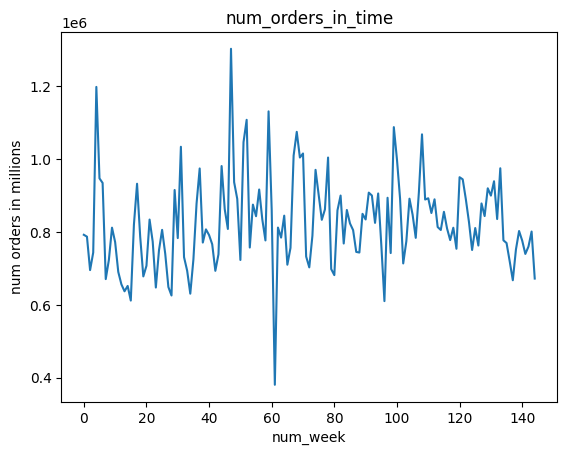

In [9]:
plot(
    x = weekly_orders.sort(pl.col("week")).select("num_orders"),
    title="num_orders_in_time",
    y_label = "num orders in millions",
    x_label = "num_week"
)


(array([161., 478., 508., 418., 344., 243., 167., 137., 109.]),
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 <BarContainer object of 9 artists>)

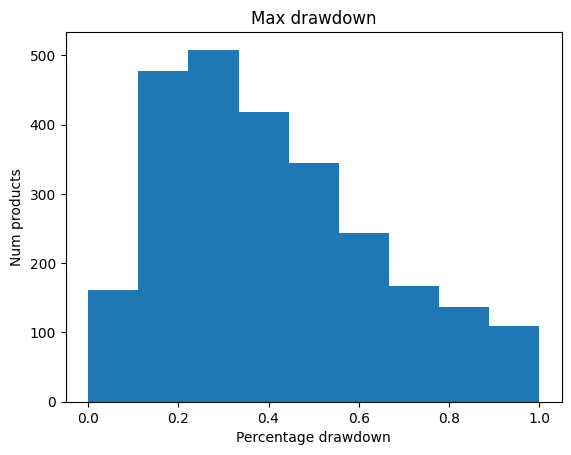

In [ ]:
weakest_week = df.filter(pl.col("week") == 62)
mean_meal_id = df.groupby("meal_id").agg(pl.mean("num_orders")).select("meal_id", pl.col("num_orders").alias("mean_orders"))
data = (
    mean_meal_id
    .join(weakest_week, on = "meal_id", how="left")
    .with_columns(
        (pl.col("num_orders") / pl.col("mean_orders")).alias("relative_diff")
    )
    .filter(pl.col("week") == 62)
    .collect()
)

plt.title("Max drawdown")
plt.ylabel("Num products")
plt.xlabel("Percentage drawdown")
plt.hist(
    data.select("relative_diff"), bins = np.linspace(0, 1, 10)
)

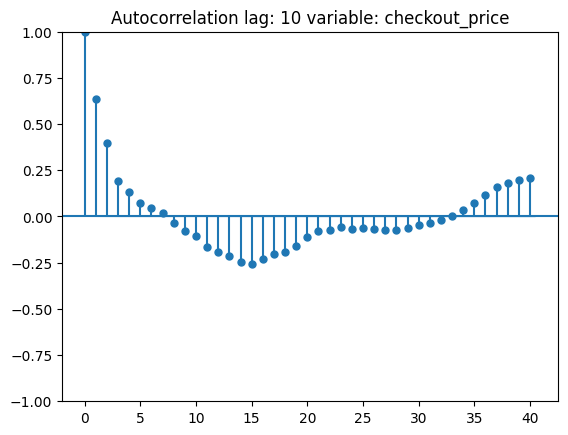

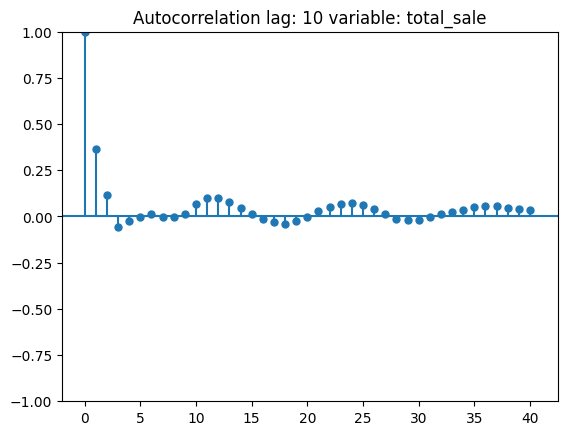

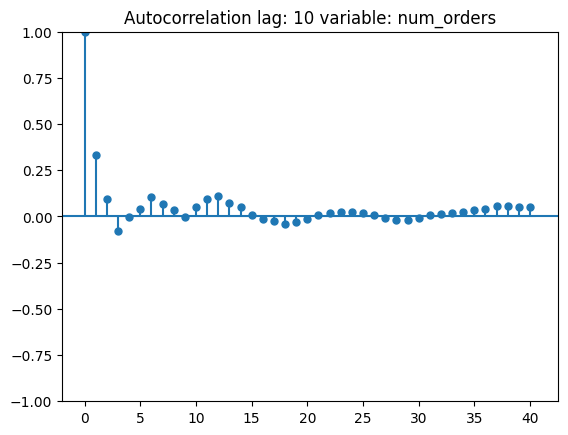

In [11]:
COLS = ['checkout_price', 'total_sale', 'num_orders']
lags = [10]
for col in COLS:
    for lag in lags:
        auto_corr_data = df.select([col, 'week']).collect().to_pandas()
        auto_corr_data.index = pd.Index(auto_corr_data['week'])
        fig = plot_acf(
            auto_corr_data[[col]].values.squeeze(), 
            lags=40, 
            title = f"Autocorrelation lag: {lag} variable: {col}"
        )
        
        

/Users/vasek/miniconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/vasek/miniconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/vasek/miniconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/vasek/miniconda

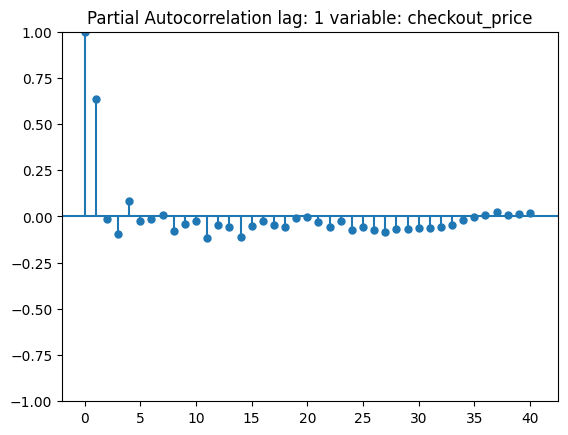

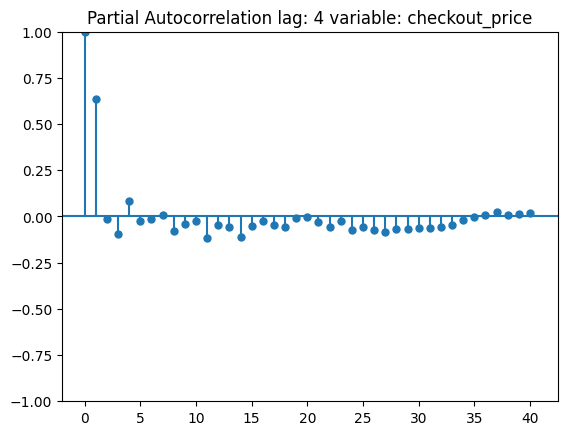

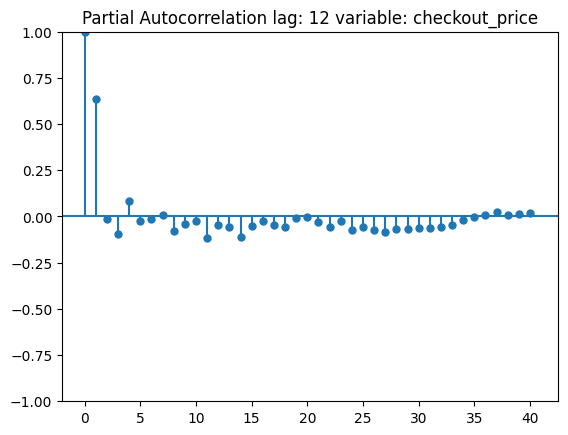

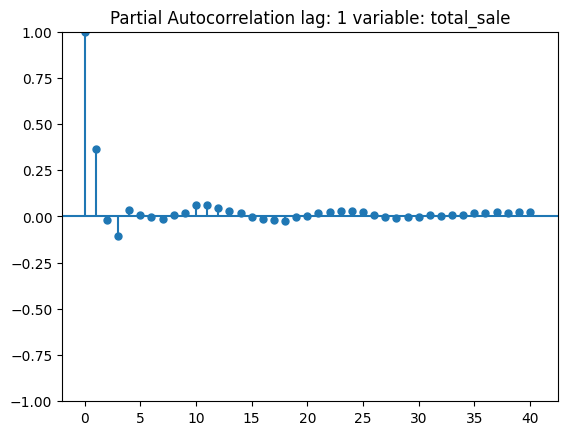

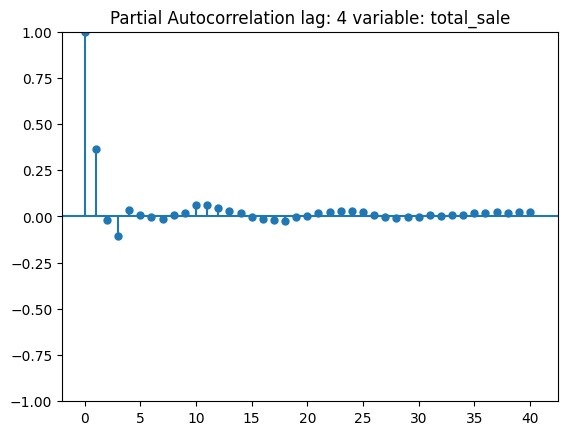

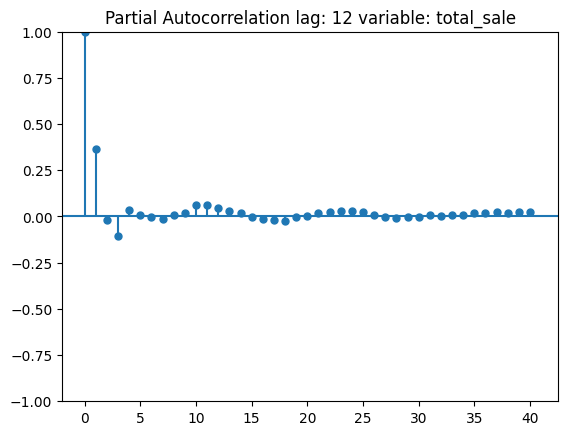

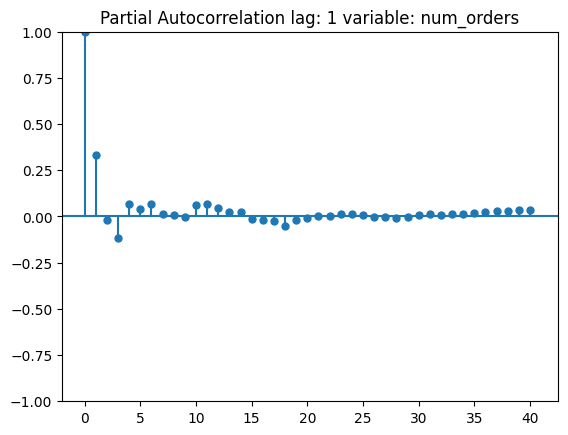

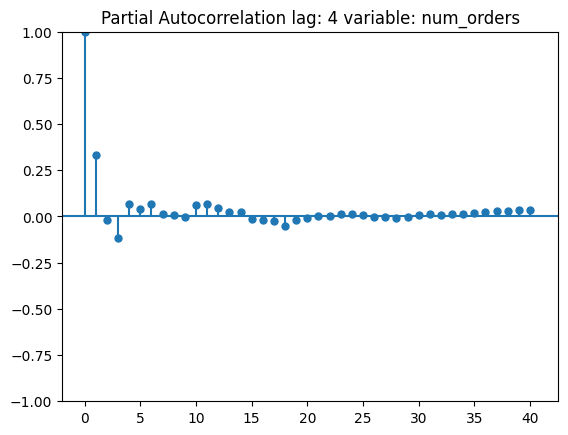

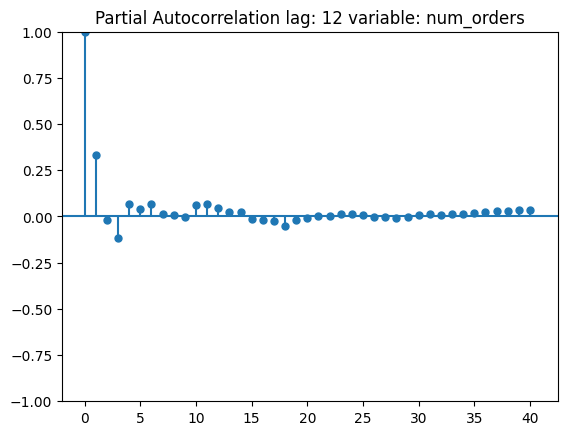

In [ ]:
COLS = ['checkout_price', 'total_sale', 'num_orders']
lags = [1, 4, 12]
for col in COLS:
    for lag in lags:
        partial_auto_corr_data = df.select(col, 'week').collect().to_pandas()
        partial_auto_corr_data.index = pd.Index(partial_auto_corr_data['week'])
        
        plot_pacf(
            partial_auto_corr_data[[col]].values.squeeze(), 
            lags=40,
            title = f"Partial Autocorrelation lag: {lag} variable: {col}"
        )
        plt.savefig(f"../data/partial_autocorrelation_graphs/pcf_{lag}_{col}.png")

In [16]:
COLS = ["mean_orders", "week", "checkout_price", "base_price", "category", "total_sale", "op_area", "relative_diff"]
df.select(COLS)

<LazyFrame [1 col, {"week": Int64}] at 0x179A512D0>

# Pairplot results
1. weekly orders are somewhat uniformly distributed
2. relative diff, total_sale is some skewed normal distribution / lognormal

## Stationarity

In [ ]:
#cols = ['checkout_price', 'base_price', "num_orders"]

#adfuller_results = {}
#for col in cols:
#  x = df.select(col).collect()
#  result = {col: adfuller(x)}
#  adfuller_results.update(result)

In [ ]:
#for k, v in adfuller_results.items():
#    print(
#        f"{k}: test_statistics: {v[0]} \t p-value: {v[1]} \t at 5%: {v[4].get('5%')}"
#    )
    

In [ ]:
#df.with_columns(pl.col("center_id").unique()).select("center_id").collect()

## Stationarity_results:
1. Data is stationary (choose statistic value is less than any from the ciritcal values)

/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_57819/2579477210.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df.collect().to_pandas().corr(), dtype=bool))
/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_57819/2579477210.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.collect().to_pandas().corr(), mask=mask, annot=True, vmin=-1, vmax=1)


<AxesSubplot: >

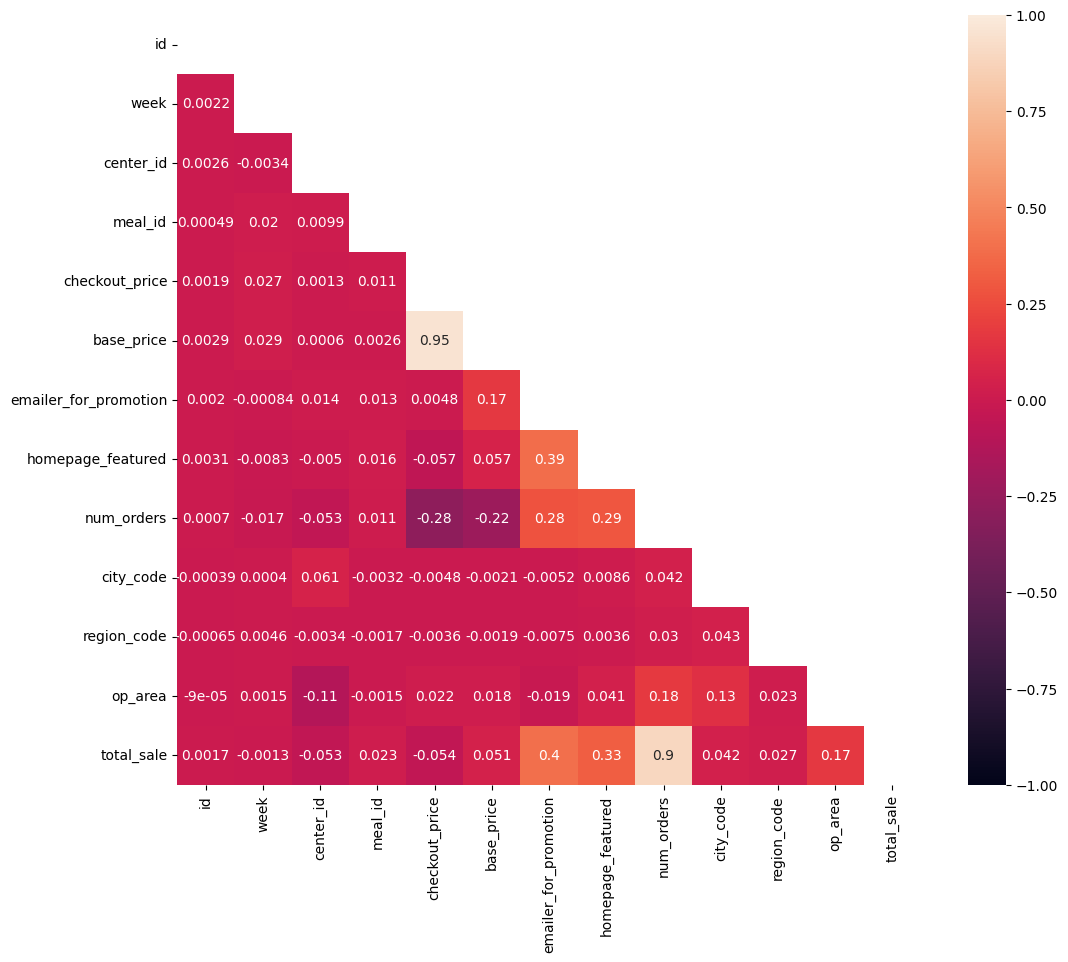

In [ ]:
mask = np.triu(np.ones_like(df.collect().to_pandas().corr(), dtype=bool))

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df.collect().to_pandas().corr(), mask=mask, annot=True, vmin=-1, vmax=1)